In [62]:
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch 
import torch.nn as nn 
from torch.utils.tensorboard import SummaryWriter
from data.utils import ImageNormalization
from models.module import ConvModule
import configs.tiny_segmentation as config
import matplotlib.pyplot as plt 
from torchsummary import summary
import cv2
import numpy as np 

In [63]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((config.image_height, config.image_width)),
    # ImageNormalization(),
])


mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((config.image_height, config.image_width)),

])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    # ImageNormalization(),
])

In [64]:
VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, mask_transform=None, transform=None):
        self.mask_transform = mask_transform
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            # makes sense, check for color code basically, set to zero else
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        # apply transforms 
        if self.transform is not None: 
            image = self.transform(image)
        # resize masks 
        if self.mask_transform is not None: 
            mask = self.mask_transform(mask)
        return image, mask


In [65]:
train_dataset =  PascalVOCDataset(root="../../research/dataset/", download=False, image_set="train", mask_transform=mask_transform, transform=train_transform)
val_dataset = PascalVOCDataset(root="../../research/dataset/", download=False, image_set="val", mask_transform=mask_transform, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=4, shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size=config.batch_size, num_workers=4, shuffle=True)


In [66]:
for img, segmentation in train_dataset: 
    break 

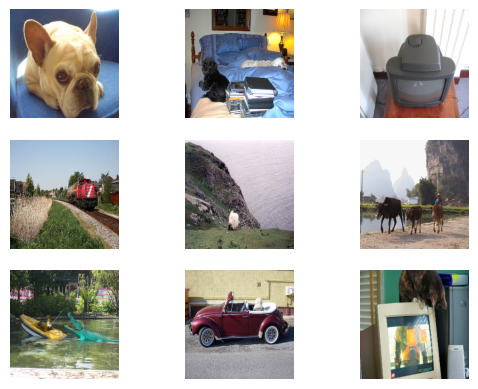

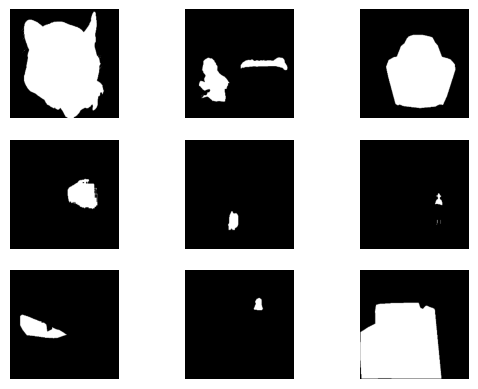

In [67]:
### check data 

for data in train_loader: 
    imgs, masks = data

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        np_img = torch.permute(imgs[i], (1, 2, 0)).numpy()
        plt.imshow(np_img)
        plt.axis("off")
    
    plt.show()

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        np_img = torch.permute(masks[i], (1, 2, 0)).numpy()
        
        for idx, label  in enumerate(VOC_COLORMAP):  
            if np.max(np_img[:, :,idx]) == 1.0: 
                plt.imshow(np_img[:, :, idx], cmap="gray")
                plt.axis("off")
    
    plt.show()
    break


In [68]:
class UnetBlock(nn.Module): 

    def __init__(
        self, 
        in_c, 
        out_c, 
        kernel_size=3,
        stride=1, 
        padding=0
    ): 
        super().__init__()
        self.conv1 = ConvModule(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = ConvModule(out_c, out_c, kernel_size, stride, padding)
        self.max_pool = nn.MaxPool2d(2, 2)

    def forward(self, x): 
        out = self.conv1(x) 
        out = self.conv2(out)
        out = self.max_pool(out)
        return out 


class ExpansiveBlock(nn.Module):

    def __init__(
        self, 
        in_c, 
        out_c, 
        kernel_size=3,
        stride=1, 
        padding=0
    ): 
        super().__init__()
        self.conv1 = ConvModule(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = ConvModule(out_c, out_c, kernel_size, stride, padding)
        self.upsampling = nn.ConvTranspose2d(out_c, out_c//2, 2, 2, 0)


    def forward(self, x): 
        out = self.conv1(x) 
        out = self.conv2(out)
        out = self.upsampling(out)
        return out



In [69]:
class Unet(nn.Module): 
    
    def __init__(self): 
        super().__init__() 
        
        self.conv1 = UnetBlock(3, 64, 3, 1)
        self.conv2 = UnetBlock(64, 128, 3, 1)
        self.conv3 = UnetBlock(128, 256, 3, 1)
        self.conv4 = UnetBlock(256, 512, 3, 1)
        self.conv5 = nn.Sequential(
            ConvModule(512, 1024, 3, 1),
            ConvModule(1024, 1024, 3, 1), 
            nn.ConvTranspose2d(1024, 512, 2, 2, 0)
        )

        self.upconv1 = ExpansiveBlock(1024, 512, 3, 1)
        self.upconv2 = ExpansiveBlock(512, 256, 3, 1)
        self.upconv3 = ExpansiveBlock(256, 128, 3, 1)

        self.conv3x3_1 = nn.Conv2d(128, 64, 3, 1)
        self.conv3x3_2 = nn.Conv2d(64, 64, 3, 1)
        self.conv1x1 = nn.Conv2d(64, 2, 1, 1)

    def forward(self, x): 

        out1 = self.conv1(x) 
        out2 = self.conv2(out1) 
        out3 = self.conv3(out2) 
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out6 = self.upconv1(torch.concat([transforms.functional.center_crop(out4,(out5.shape[2], out5.shape[3])), out5], dim=1))
        out7 = self.upconv2(torch.concat([transforms.functional.center_crop(out3,(out6.shape[2], out6.shape[3])), out6], dim=1))
        out8 = self.upconv3(torch.concat([transforms.functional.center_crop(out2,(out7.shape[2], out7.shape[3])), out7], dim=1))
        out9 = self.conv3x3_1(torch.concat([transforms.functional.center_crop(out1,(out8.shape[2], out8.shape[3])), out8], dim=1))
        out = self.conv3x3_2(out9) 
        out = self.conv1x1(out)

        return out



In [ ]:
summary(Unet().cuda(), (3, 572, 572))

Layer (type:depth-idx)                   Output Shape              Param #
├─UnetBlock: 1-1                         [-1, 64, 125, 125]        --
|    └─ConvModule: 2-1                   [-1, 64, 253, 253]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 253, 253]        1,728
|    |    └─BatchNorm2d: 3-2             [-1, 64, 253, 253]        128
|    |    └─ReLU: 3-3                    [-1, 64, 253, 253]        --
|    └─ConvModule: 2-2                   [-1, 64, 251, 251]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 251, 251]        36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 251, 251]        128
|    |    └─ReLU: 3-6                    [-1, 64, 251, 251]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 125, 125]        --
├─UnetBlock: 1-2                         [-1, 128, 60, 60]         --
|    └─ConvModule: 2-4                   [-1, 128, 123, 123]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 123, 123]       73,728
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─UnetBlock: 1-1                         [-1, 64, 125, 125]        --
|    └─ConvModule: 2-1                   [-1, 64, 253, 253]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 253, 253]        1,728
|    |    └─BatchNorm2d: 3-2             [-1, 64, 253, 253]        128
|    |    └─ReLU: 3-3                    [-1, 64, 253, 253]        --
|    └─ConvModule: 2-2                   [-1, 64, 251, 251]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 251, 251]        36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 251, 251]        128
|    |    └─ReLU: 3-6                    [-1, 64, 251, 251]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 125, 125]        --
├─UnetBlock: 1-2                         [-1, 128, 60, 60]         --
|    └─ConvModule: 2-4                   [-1, 128, 123, 123]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 123, 123]       73,728
| 